# Perpetual Path Length
- PPL is a metric that is introduced as part of StyleGAN to evalute how well a gnerator manages to smoothly interpolate between points in its latent space.
- If you travel between two points images produced by a generator on a straight line in the latent space, it measures the total "jarringness" of the interpolation, When you add together the jarringness of each step
- `StyleGAN2` - correlates with consistency and stability of shapes, that led to one of the major changes between the two papers


## Perpetual Similarity
- Like FID, PPL uses the feature embeddings of DConvNN
- It is the distance between t20 image embedding
- It is closely similar to the distance between two feature vectors, with one difference
- The features are passed through a learned transformtion, which is trained to match human intuition on image similarity
- Specifically, when shown 2 images with various transformations from a base image - the LPIPS, Learned Perceptual Image Patch Similarity5.
- LPIPS metric is meant to have a lower distance for the image that people think is closer

In [ ]:
# !pip install lpips

In [1]:
import lpips
loss_fn_vgg = lpips.LPIPS(net='vgg')

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /Users/shankar/dev/tools/anaconda3/envs/torch/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


In [2]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import CelebA

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
from generator import Generator
from gans_utils import show_tensor_images

In [4]:
z_dim = 64
device = 'cpu'

gen = Generator(z_dim).to(device)
gen.load_state_dict(torch.load(f"../../celeba/pretrained_celeba.pth", map_location=torch.device(device))["gen"])
gen = gen.eval()

### From LPIPS to PPL
Perpetual path length builds directly on the LPIPS metric

- StyleGAN does not operate directly on the randomly sampled laten vector
- It learns a mapping $f$ from $z$ to $w$ - that is $f(z) = w$
- ie there are two spaces over wich you can calculate PPL

#### Linear Interpolation ($w$-space)
For the $w$ space, PPL is defined as follows using linear interpolation.

First, you sample two points in $w$-space, $w_1 = f(z_1)$ and $w_2 = f(z_2)$ - from randomly sampled points in $z$-space. For simplicity, we will let $f$ be the identity function

In [5]:
map_fn = nn.Identity()
w_1, w_2 = map_fn(torch.randn(1, z_dim)), map_fn(torch.randn(1, z_dim))

In [6]:
x = torch.randn(1, z_dim)
x

tensor([[-0.7205, -1.6847,  0.0128, -0.2560, -0.2029, -0.1019,  1.4497,  0.6856,
         -1.4219, -0.0796,  2.2689, -1.3475,  0.2152,  1.5086,  0.9154,  0.2868,
         -1.1332, -0.5811,  0.3696, -1.1742,  1.3489,  0.0813, -0.8726, -1.1079,
         -1.0668,  0.6317, -0.1935, -1.0297, -0.8981, -0.5514, -0.3748, -0.4804,
          0.8844, -0.6326, -0.3634, -0.2232, -0.3755, -1.7077,  1.1272, -1.2323,
          0.6116, -0.4921, -0.8778,  0.1506,  1.5381, -0.6457, -1.1055, -1.9267,
          0.3923,  0.3265, -0.4505,  0.2812, -1.4531, -1.0537,  0.0562,  1.6375,
         -0.0779,  0.9646, -1.5910, -0.3198,  0.7092, -0.3452, -0.8008, -0.3188]])

In [7]:
map_fn(x)

tensor([[-0.7205, -1.6847,  0.0128, -0.2560, -0.2029, -0.1019,  1.4497,  0.6856,
         -1.4219, -0.0796,  2.2689, -1.3475,  0.2152,  1.5086,  0.9154,  0.2868,
         -1.1332, -0.5811,  0.3696, -1.1742,  1.3489,  0.0813, -0.8726, -1.1079,
         -1.0668,  0.6317, -0.1935, -1.0297, -0.8981, -0.5514, -0.3748, -0.4804,
          0.8844, -0.6326, -0.3634, -0.2232, -0.3755, -1.7077,  1.1272, -1.2323,
          0.6116, -0.4921, -0.8778,  0.1506,  1.5381, -0.6457, -1.1055, -1.9267,
          0.3923,  0.3265, -0.4505,  0.2812, -1.4531, -1.0537,  0.0562,  1.6375,
         -0.0779,  0.9646, -1.5910, -0.3198,  0.7092, -0.3452, -0.8008, -0.3188]])

You will use your generator to produce two images interpolating between $w_1$ and $w_2$, where the amount of $w_1$ is $t$, one where the amount of $w_1$ is $t+\epsilon$. You can think of $t$ as sampling a random point along the path interpolating between $w_1$ and $w_2$.

You can use the `torch.lerp` function for linear interpolation, and sample a random $t$ uniformly from 0 to 1 using `torch.rand`. Also, here we can set $\epsilon = 2 \cdot 10^{-1}$ for visualization, even though in the StyleGAN paper $\epsilon = 10^{-4}$.

In [8]:
eps = 2e-1
t = torch.rand(1)
interpolated_1 = torch.lerp(w_1, w_2, t)
interpolated_2 = torch.lerp(w_1, w_2, t + eps)
y_1, y_2 = gen(interpolated_1), gen(interpolated_2)

In [9]:
t

tensor([0.5445])

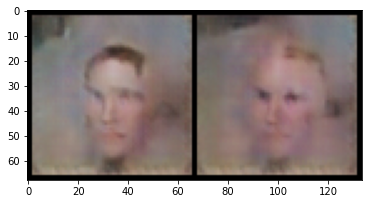

Image LPIPS is 0.2343052625656128


In [10]:
show_tensor_images(torch.cat([y_1, y_2]))
cur_lpips = loss_fn_vgg(y_1, y_2).item()
print(f'Image LPIPS is {cur_lpips}')

Finally, you need to account for the impact of different values of $\epsilon$, so that the perceptual path length converges $\epsilon\rightarrow \infty$. In order to do this, PPL divides by $\epsilon^2$

In [11]:
ppl = cur_lpips / (eps ** 2)
print(f'Our final sample PPL is {ppl}')

Our final sample PPL is 5.857631564140319


$$PPL_w = \mathbb{E}\left[\frac{1}{\epsilon^2}
d_{LPIPS}\left(G(lerp(w_1, w_2, t)),  G(lerp(w_1, w_2, t+\epsilon))\right)
\right]$$

You'll notice the expectation symbol: that's because this is all repeated many times in order to approximate PPL.

In [13]:
def ppl_w(gen, map_fn, num_samples=10, eps=1e-4):
    """
    Perceptual paath length function: combines the above steps into on PPL function
    """
    # Sample of a batch of num_samples pairs of points
    w_1 = map_fn(torch.randn(num_samples, z_dim))
    w_2 = map_fn(torch.randn(num_samples, z_dim))
    
    # Sample num saples points along the interpolated lines
    t = torch.randn(num_samples)[:, None]
    # Interpolate between the points
    interpolated_1 = torch.lerp(w_1, w_2, t)
    interpolated_2 = torch.lerp(w_1, w_2, t + eps)
    # Generated the interpolated images
    y_1, y_2 = gen(interpolated_1), gen(interpolated_2)
    # Calculate teh per sample LPIPS
    cur_lpips = loss_fn_vgg(y_1, y_2)
    # Calculate the PPL from the LPIPS
    ppl = cur_lpips / (eps ** 2)
    
    return ppl.mean()

print(f'PPL_w: {ppl_w(gen, nn.Identity()).item()}')

PPL_w: 9.232742309570312


#### Spherical Interpolation (z-space)
- Sample points in $z$ from a Gaussian, use spherical interpolation instead of linear interpolation to interpolate $z$-space
- Use `scipy.spatial.geometric_slerp`

$$slerp(z_1, z_2, t) = \frac{\sin[(1 - t) \cdot \Omega]}{\sin\Omega} z_1 + \frac{\sin[t \cdot \Omega]}{\sin\Omega} z_2$$

where $ \Omega = \cos^{-1}(\mathrm{dot}(\bar{z}_1, \bar{z}_2))$ and $\bar{x}$ denotes the normalized version of x.

In [15]:
def normalize(x):
    return x / torch.norm(x, dim=1)[:, None]

def get_omega(x, y):
    return torch.acos((normalize(x) * normalize(y)).sum(1))

def slerp(x, y, t):
    omega = get_omega(x, y)[:, None]
    c1 = torch.sin(omega * (1-t)) / torch.sin(omega)
    c2 = torch.sin(omega * t) / torch.sin(omega)
    return c1 * x + c2 * y

In [18]:
def ppl_z(gen, num_samples=10, eps=1e-4):
    
    # Sample of a batch of num_samples pairs of points
    z_1 = torch.randn(num_samples, z_dim)
    z_2 = torch.randn(num_samples, z_dim)
    
    # Sample num_samples points along the interpolated lines
    t = torch.rand(num_samples)[:, None]
    
    # Interpolate between the points
    interpolated_1 = slerp(z_1, z_2, t)
    interpolated_2 = slerp(z_1, z_2, t + eps)
    
    # Generated the interpolated images
    y_1, y_2 = gen(interpolated_1), gen(interpolated_2)
    
    # Calculate the per-sample LPIPS
    cur_lpips = loss_fn_vgg(y_1, y_2)
    
    # Calculate the PPL from the LPIPS
    ppl = cur_lpips / (eps ** 2)
    
    return ppl.mean()

print(f'PPL_z: {ppl_z(gen).item()}')

PPL_z: 18.534107208251953
